<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/MakeTilesLowResNLCDLANDSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
import gdal
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
os.mkdir("RawData")
os.mkdir("TiledData")

In [ ]:
os.mkdir("./TiledData"+"/im1")
os.mkdir("./TiledData"+"/im2")
os.mkdir("./TiledData"+"/label1")
os.mkdir("./TiledData"+"/label2")

In [ ]:
!wget https://raw.githubusercontent.com/kyle-gao/GRSS_TrackMSD2021/main/ABPN_NLCDSuperRes/validation_tile_index.txt

--2021-03-17 16:44:34--  https://raw.githubusercontent.com/kyle-gao/GRSS_TrackMSD2021/main/ABPN_NLCDSuperRes/validation_tile_index.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249 [text/plain]
Saving to: ‘validation_tile_index.txt’

validation_tile_ind 100%[===================>]     249  --.-KB/s    in 0s      

2021-03-17 16:44:34 (12.6 MB/s) - ‘validation_tile_index.txt’ saved [249/249]



In [ ]:
with open("/content/validation_tile_index.txt") as file:
  tiles = file.readlines()
tiles = list(map(lambda tile: tile.replace("\n",""),tiles))

In [ ]:
url = "https://dfc2021.blob.core.windows.net/competition-data/DATASET-YEAR/TILE_DATASET-YEAR.tif"

In [ ]:
def get_url(dataset,tile,year):
  """Args:
  -dataset:"landsat" or "nlcd"
  -tiles: valid tile eg. "2792"
  -year" "2013" or "2016"
  """
  url = "https://dfc2021.blob.core.windows.net/competition-data/DATASET-YEAR/TILE_DATASET-YEAR.tif"
  return url.replace("DATASET",dataset).replace("YEAR",year).replace("TILE",tile)

In [ ]:
for tile in tiles:
  urllib.request.urlretrieve(get_url("landsat",tile,"2013"),"./RawData/"+"landast_2013_"+tile)
  urllib.request.urlretrieve(get_url("landsat",tile,"2016"),"./RawData/"+"landast_2016_"+tile)
  urllib.request.urlretrieve(get_url("nlcd",tile,"2013"),"./RawData/"+"nlcd_2013_"+tile)
  urllib.request.urlretrieve(get_url("nlcd",tile,"2016"),"./RawData/"+"nlcd_2016_"+tile)

In [ ]:
size = (512,512)
padding = 'VALID'


def write_tiles(tiles,size=(512,512),padding='VALID',save_dir = "./TiledData"):
  """
  Args-
  filenames: tensorflow list_files dataset object
  size: tuple of ints
  padding=one of "VALID" "SAME"
  save_dir-save directory
  """
  (h,w) = size
  for tile in tiles:
    img1 = gdal.Open("./RawData/"+"landast_2013_"+tile).ReadAsArray()[1:4,:,:]
    img1 = img1.transpose([1,2,0])
    img1 = img1[:,:,::-1] #bgr to rgb
    img1 = tf.expand_dims(img1/np.max(img1),axis=0)

    img2 = gdal.Open("./RawData/"+"landast_2016_"+tile).ReadAsArray()[1:4,:,:]
    img2 = img2.transpose([1,2,0])
    img2 = img2[:,:,::-1]
    img2 = tf.expand_dims(img2/np.max(img2),axis=0)

    label1 =  gdal.Open("./RawData/"+"nlcd_2013_"+tile).ReadAsArray()
    label1 = tf.expand_dims(tf.expand_dims(label1,0),axis=-1)

    label2 =  gdal.Open("./RawData/"+"nlcd_2016_"+tile).ReadAsArray()
    label2 = tf.expand_dims(tf.expand_dims(label2,0),axis=-1)


    #(H,W,3)    
    
    image_tiles1 =  tf.image.extract_patches(images=img1,
                           sizes=[1,h, w, 1],
                           strides=[1,h, w, 1],
                           rates=[1, 1, 1, 1],
                           padding=padding)
    image_tiles1 = tf.reshape(image_tiles1, [-1,h,w,3])

    image_tiles2 =  tf.image.extract_patches(images=img2,
                           sizes=[1,h, w, 1],
                           strides=[1,h, w, 1],
                           rates=[1, 1, 1, 1],
                           padding=padding)
    image_tiles2 = tf.reshape(image_tiles2, [-1,h,w,3])

    label_tiles1 =  tf.image.extract_patches(images=label1,
                           sizes=[1,h, w, 1],
                           strides=[1,h, w, 1],
                           rates=[1, 1, 1, 1],
                           padding=padding)
    label_tiles1 = tf.reshape(label_tiles1, [-1,h,w,1])

    label_tiles2 =  tf.image.extract_patches(images=label2,
                           sizes=[1,h, w, 1],
                           strides=[1,h, w, 1],
                           rates=[1, 1, 1, 1],
                           padding=padding)
    label_tiles2 = tf.reshape(label_tiles2, [-1,h,w,1])



    for i in range(label_tiles1.shape[0]):

      im1_fn =  save_dir+"/im1/"+tile+"_patch_"+str(i)+".png"
      im2_fn =  save_dir+"/im2/"+tile+"_patch_"+str(i)+".png"

      label1_fn =  save_dir+"/label1/"+tile+"_patch_"+str(i)+".png"
      label2_fn =  save_dir+"/label2/"+tile+"_patch_"+str(i)+".png"

      tf.keras.preprocessing.image.save_img(im1_fn,image_tiles1[i,:,:,:],scale=True)
      tf.keras.preprocessing.image.save_img(im2_fn,image_tiles2[i,:,:,:],scale=True)

      tf.keras.preprocessing.image.save_img(label1_fn,label_tiles1[i,:,:,:],scale=False)
      tf.keras.preprocessing.image.save_img(label2_fn,label_tiles2[i,:,:,:],scale=False)




    print(im1_fn)

In [ ]:
write_tiles(tiles)

./TiledData/im1/1950_patch_48.png
./TiledData/im1/2002_patch_48.png
./TiledData/im1/2003_patch_48.png
./TiledData/im1/2283_patch_34.png
./TiledData/im1/2448_patch_48.png
./TiledData/im1/2449_patch_48.png
./TiledData/im1/2608_patch_48.png
./TiledData/im1/2661_patch_48.png
./TiledData/im1/2662_patch_48.png
./TiledData/im1/2663_patch_48.png
./TiledData/im1/2664_patch_48.png
./TiledData/im1/2716_patch_48.png
./TiledData/im1/2717_patch_48.png
./TiledData/im1/2934_patch_48.png
./TiledData/im1/2935_patch_48.png
./TiledData/im1/2988_patch_48.png
./TiledData/im1/2989_patch_48.png
./TiledData/im1/3039_patch_48.png
./TiledData/im1/3040_patch_48.png
./TiledData/im1/3097_patch_48.png
./TiledData/im1/3098_patch_48.png
./TiledData/im1/3136_patch_48.png
./TiledData/im1/3137_patch_48.png
./TiledData/im1/3151_patch_48.png
./TiledData/im1/3152_patch_48.png
./TiledData/im1/3191_patch_48.png
./TiledData/im1/3257_patch_48.png
./TiledData/im1/3258_patch_48.png
./TiledData/im1/3259_patch_48.png
./TiledData/im

In [ ]:
import shutil
shutil.make_archive("BitemporalLandsatNLCD",format="zip",root_dir = "/content",base_dir = "TiledData")

'/content/BitemporalLandsatNLCD.zip'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
shutil.copy2("/content/BitemporalLandsatNLCD.zip","/content/drive/MyDrive")

'/content/drive/MyDrive/BitemporalLandsatNLCD.zip'

In [ ]:
labels = os.listdir("/content/TiledData/label1")

In [ ]:
uniques = []
for i in labels:
  pathname = "/content/TiledData/label1/"+i
  label = tf.keras.preprocessing.image.load_img(pathname,color_mode="grayscale")
  label = tf.keras.preprocessing.image.img_to_array(label)
  uniques = np.append(uniques,np.unique(label))
  uniques = np.unique(uniques)
uniques

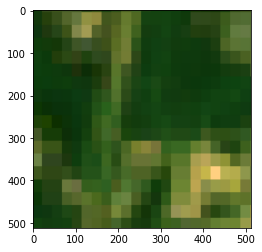

In [ ]:
img = tf.keras.preprocessing.image.load_img("/content/TiledData/im1/1950_patch_0.png")
img = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(img/255.0)